# Sensor Noise Modeling

Text(0.5, 0, 'Frequency (Hz)')

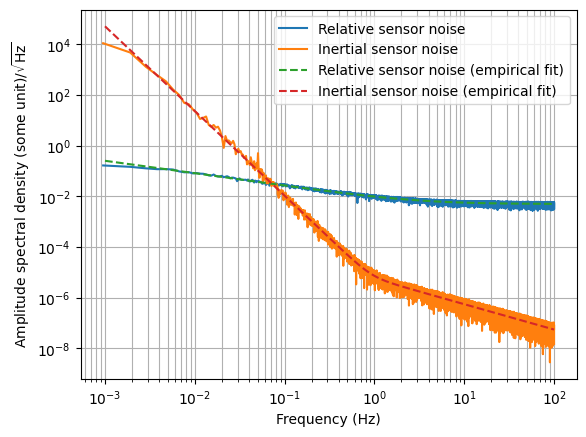

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol


# Load sensor noise data generated earlier.
with open("noise_spectrum_frequency.pkl", "rb") as fh:
    f = pickle.load(fh)
with open("noise_spectrum_relative.pkl", "rb") as fh:
    noise_relative = pickle.load(fh)
with open("noise_spectrum_inertial.pkl", "rb") as fh:
    noise_inertial = pickle.load(fh)

# Get rid of the DC value
noise_relative = noise_relative[f>0]
noise_inertial = noise_inertial[f>0]
f = f[f>0]

# Fitting an empirical model is helpful but not necessary.
# Here we assume we know the empirical form of the noise and
# simply use a generic minimization algorithm to fit the empirical models.
def noise_model(f, na, nb, a, b):
    na = 10**na  # Parameter rescaling.
    nb = 10**nb
    return np.sqrt((na/f**a)**2 + (nb/f**b)**2)


def cost(args, xdata, ydata):
    na, nb, a, b = args
    ymodel = noise_model(xdata, na, nb, a, b)
    error = kontrol.curvefit.error_func.noise_error(ydata, ymodel)  # mean square logarithmic error.
    return error


res_relative = scipy.optimize.minimize(cost, args=(f, noise_relative), x0=[-2.07, -2.3, 0.5, 0])
res_inertial = scipy.optimize.minimize(cost, args=(f, noise_inertial), x0=[-5.46, -5.23, 3.5, 1])
# ^If we cannot guess the x0 values, we can try to use a global optimization alogrithm
# such as differential evolution instead.

# With the empirical model found, we can define a logspace frequency axis,
# which helps a lot with the next steps.
f_log = np.logspace(-3, 2, 1024)  # And with less data points so fit faster.
noise_relative_empirical = noise_model(f_log, *res_relative.x)
noise_inertial_empirical = noise_model(f_log, *res_inertial.x)

# Visualize
plt.loglog(f, noise_relative, label="Relative sensor noise")
plt.loglog(f, noise_inertial, label="Inertial sensor noise")
plt.loglog(f_log, noise_relative_empirical, "--", label="Relative sensor noise (empirical fit)")
plt.loglog(f_log, noise_inertial_empirical, "--", label="Inertial sensor noise (empirical fit)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

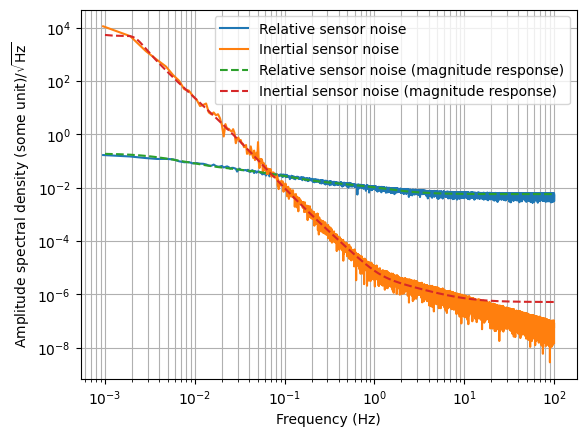

In [2]:
# Now we see the empirical model that we obtained fits the noise spectrum well
# we can model the empirical model itself instead of the measured noise data.
# H-infinity method requires transfer functions to be flat at both ends
# so we need to flatten the data.
# Select the frequency band of interests.
f_lower = 2e-3
f_upper = 1e1
noise_relative_flat = noise_relative_empirical.copy()
noise_inertial_flat = noise_inertial_empirical.copy()
noise_relative_flat[f_log<f_lower] = noise_relative_empirical[f_log>f_lower][0]
noise_relative_flat[f_log>f_upper] = noise_relative_empirical[f_log<f_upper][-1]
noise_inertial_flat[f_log<f_lower] = noise_inertial_empirical[f_log>f_lower][0]
noise_inertial_flat[f_log>f_upper] = noise_inertial_empirical[f_log<f_upper][-1]

# Model the flattened spectrums with magnitude responses
order_relative = 3  # Order of the transfer functions. Guess.
order_inertial = 4
tf_relative = kontrol.curvefit.spectrum_fit(f_log, noise_relative_flat,
                                          nzero=order_relative, npole=order_relative)
tf_inertial = kontrol.curvefit.spectrum_fit(f_log, noise_inertial_flat,
                                          nzero=order_inertial, npole=order_inertial)

# Optionally inspect.
plt.loglog(f, noise_relative, label="Relative sensor noise")
plt.loglog(f, noise_inertial, label="Inertial sensor noise")
# plt.loglog(f_log, noise_relative_empirical, "--", label="Relative sensor noise (empirical fit)")
# plt.loglog(f_log, noise_inertial_empirical, "--", label="Inertial sensor noise (empirical fit)")
# plt.loglog(f_log, noise_relative_flat, "-.", label="Relative sensor noise (flat ends)")
# plt.loglog(f_log, noise_inertial_flat, "-.", label="Inertial sensor noise (flat ends)")
plt.loglog(f_log, abs(tf_relative(1j*2*np.pi*f_log)), "--", label="Relative sensor noise (magnitude response)")
plt.loglog(f_log, abs(tf_inertial(1j*2*np.pi*f_log)), "--", label="Inertial sensor noise (magnitude response)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [3]:
# Export the transfer functions
tf_relative.save("tf_relative.pkl")
tf_inertial.save("tf_inertial.pkl")